In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [2]:
targetUser = 's002'

In [3]:
data = pd.read_csv('DSL-StrongPasswordData.csv') # import the dataset
trainSet = data.copy() # create a copy that will be used to split the test and train sets

In [4]:
X_test = np.empty((0, 31))
y_test = np.empty(0,)

In [5]:
for user in data['subject'].unique()[0:3]:
    
    # Select 50 random records for this user
    user_records = trainSet[trainSet['subject'] == user].sample(n=50, random_state=42)
    
    #Remove record from trainSet
    trainSet = trainSet.drop(user_records.index)
    
    # Append the typing data to X_test
    X_test = np.vstack((X_test, user_records[['H.period', 'DD.period.t', 'UD.period.t', 'H.t', 'DD.t.i', 'UD.t.i', 'H.i', 'DD.i.e', 'UD.i.e', 'H.e', 'DD.e.five', 'UD.e.five', 'H.five', 'DD.five.Shift.r', 'UD.five.Shift.r', 'H.Shift.r', 'DD.Shift.r.o', 'UD.Shift.r.o', 'H.o', 'DD.o.a', 'UD.o.a', 'H.a', 'DD.a.n', 'UD.a.n', 'H.n', 'DD.n.l', 'UD.n.l', 'H.l', 'DD.l.Return', 'UD.l.Return', 'H.Return']].values))
    
    # Append the subject labels to y_test
    y_test = np.hstack((y_test, np.where(user_records['subject'] == targetUser, 1, 0)))
    
trainSet['subject'] = np.where(trainSet['subject'] == targetUser, 1, 0)

In [6]:
#scaler = StandardScaler()
#X_test = scaler.fit_transform(X_test) # Normalising X for testSet

In [7]:
model = tf.keras.models.Sequential()

In [8]:
model.add(tf.keras.layers.Dense(128, input_shape=X_test.shape[1:], activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=10,  # number of epochs with no improvement after which training will be stopped
    verbose=1,  # whether to print updates to the console
    restore_best_weights=True  # whether to restore the weights from the epoch with the best monitored metric
)

In [11]:
train_sizes = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350]

roc_auc_scores = []
roc_auc_binary_scores = []

# Loop through each training data subset size and train/evaluate the model
for size in train_sizes:
    # Reset the model to an untrained state
    model.reset_states()
    
    user_records = shuffle(trainSet[trainSet['subject'] == 1], random_state = 42)
    non_user_records = shuffle(trainSet[trainSet['subject'] == 0], random_state = 42)
    
    train_user_records = user_records.groupby('subject').apply(lambda x: x.sample(size))
    train_non_user_records = non_user_records.groupby('subject').apply(lambda x: x.sample(size))
    
    # Subset the training data to the specified size
    train_data_subset = pd.concat([train_user_records, train_non_user_records])
    
    # Shuffle the data
    train_data_subset = shuffle(train_data_subset, random_state = 42)
    
    # Split dataset into X and y
    X_train = train_data_subset.drop(['subject', 'sessionIndex', 'rep'], axis=1).values
    y_train = train_data_subset['subject']
    
    # Normalising X
    #X_train = scaler.fit_transform(X_train) # Normalising X for trainSet
    
    
    # Train the model on the subset of training data
    model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])
    
    # Predict the test set
    prediction = model.predict(X_test)
    
    # Classify the prediction results
    prediction_binary = np.where(prediction > 0.90, 1, 0)
    
    # Calculate AUC based on prediction
    # Calculate false-pos and true-pos rates
    fpr, tpr, thresholds = roc_curve(y_test, prediction_binary)
    roc_auc = auc(fpr, tpr)    
    
    tn, fp, fn, tp = confusion_matrix(y_test, prediction_binary, labels=[0,1]).ravel()
    
    if tp + fp > 0:
        precision = tp / (tp + fp)
    else:
        precision = 0
    
    if tp + fn > 0:
        recall = tp / (tp + fn)
    else:
        recall = 0

    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    
    # Evaluate the model on the test set and record the ROC AUC score
    roc_auc_binary_scores.append({'Size': size, 'FPR': fpr, 'TPR': tpr, 'AUC': roc_auc, 'F1': f1, 'P': precision, 'R': recall})
    # Calculate AUC based on prediction
    # Calculate false-pos and true-pos rates
    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    roc_auc = auc(fpr, tpr)
    
    # Evaluate the model on the test set and record the ROC AUC score
    roc_auc_scores.append({'Size': size, 'FPR': fpr, 'TPR': tpr, 'AUC': roc_auc})


Epoch 1/50
2/2 [==============================] - 0s 93ms/step - loss: 0.6852 - accuracy: 0.5000 - val_loss: 0.7092 - val_accuracy: 0.3333
Epoch 2/50
2/2 [==============================] - 0s 19ms/step - loss: 0.6691 - accuracy: 0.5600 - val_loss: 0.7045 - val_accuracy: 0.3533
Epoch 3/50
2/2 [==============================] - 0s 18ms/step - loss: 0.6542 - accuracy: 0.6000 - val_loss: 0.7035 - val_accuracy: 0.3667
Epoch 4/50
2/2 [==============================] - 0s 18ms/step - loss: 0.6456 - accuracy: 0.6000 - val_loss: 0.7029 - val_accuracy: 0.3933
Epoch 5/50
2/2 [==============================] - 0s 19ms/step - loss: 0.6340 - accuracy: 0.7200 - val_loss: 0.6889 - val_accuracy: 0.5600
Epoch 6/50
2/2 [==============================] - 0s 20ms/step - loss: 0.6206 - accuracy: 0.8200 - val_loss: 0.6809 - val_accuracy: 0.6133
Epoch 7/50
2/2 [==============================] - 0s 19ms/step - loss: 0.6087 - accuracy: 0.8200 - val_loss: 0.6712 - val_accuracy: 0.6600
Epoch 8/50
2/2 [===========

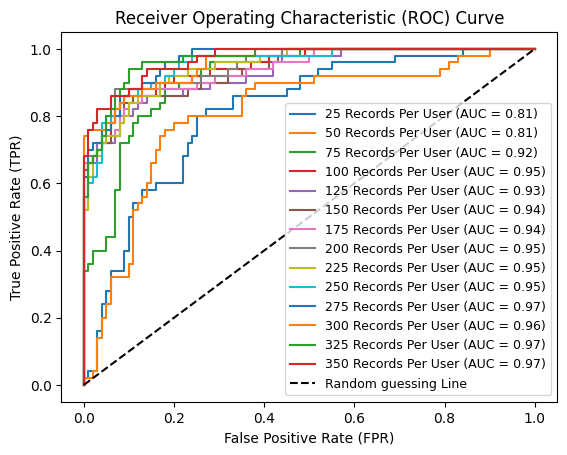

In [12]:
for x in roc_auc_scores:
    plt.plot(x['FPR'], x['TPR'], label='{} Records Per User (AUC = {:.2f})'.format(x['Size'], x['AUC']))

    
plt.plot([0, 1], [0, 1], 'k--', label='Random guessing Line')  # Random guessing line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right", fontsize=9)
plt.show()

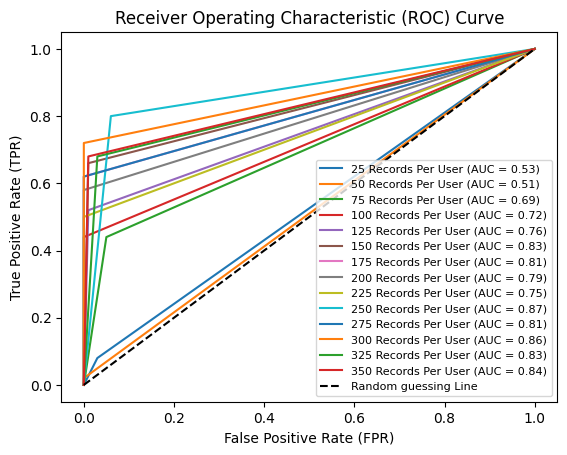

In [13]:
for x in roc_auc_binary_scores:
    plt.plot(x['FPR'], x['TPR'], label='{} Records Per User (AUC = {:.2f})'.format(x['Size'], x['AUC']))

plt.plot([0, 1], [0, 1], 'k--', label='Random guessing Line')  # Random guessing line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right", fontsize=8)
plt.show()

In [14]:
AUC = []
Binary_AUC = []
F1 = []
Precision = []
Recall = []

for x in roc_auc_scores:
    AUC.append(x['AUC'])
    
for x in roc_auc_binary_scores:
    
    Binary_AUC.append(x['AUC'])
    F1.append(x['F1'])
    Precision.append(x['P'])
    Recall.append(x['R'])

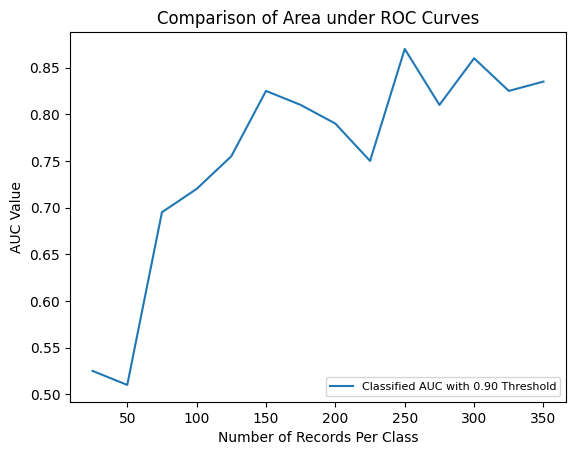

In [15]:
plt.plot(train_sizes, Binary_AUC, label="Classified AUC with 0.90 Threshold")
plt.xlabel('Number of Records Per Class')
plt.ylabel('AUC Value')
plt.title('Comparison of Area under ROC Curves')
plt.legend(loc="lower right", fontsize=8)
plt.show()

In [16]:
for x in range(1, len(Binary_AUC)):
    rateOfIncrease = ((Binary_AUC[x] - Binary_AUC[x-1]))
    print(str(round(rateOfIncrease, 4)))
    
for x in range(0, len(Binary_AUC)):
    print(round(Binary_AUC[x], 2))

-0.015
0.185
0.025
0.035
0.07
-0.015
-0.02
-0.04
0.12
-0.06
0.05
-0.035
0.01
0.52
0.51
0.7
0.72
0.76
0.82
0.81
0.79
0.75
0.87
0.81
0.86
0.82
0.84


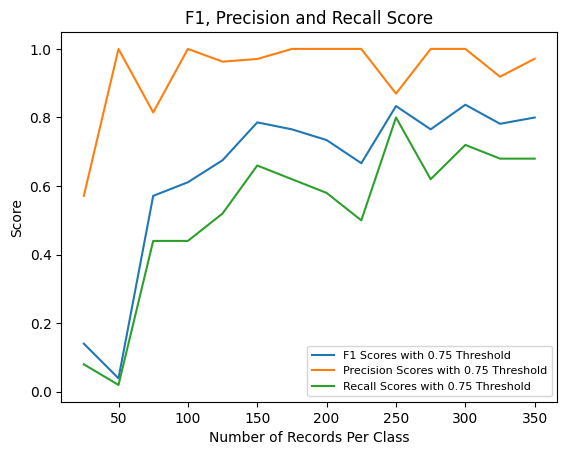

In [21]:
plt.plot(train_sizes, F1, label="F1 Scores with 0.75 Threshold")
plt.plot(train_sizes, Precision, label="Precision Scores with 0.75 Threshold")
plt.plot(train_sizes, Recall, label="Recall Scores with 0.75 Threshold")
plt.title('F1, Precision and Recall Score')
plt.xlabel('Number of Records Per Class')
plt.ylabel('Score')
plt.legend(loc="lower right", fontsize=8)
plt.show()

In [18]:
print("F1:", F1)
print("Precision:", Precision)
print("Recall:", Recall)

print(len(prediction))

F1: [0.14035087719298248, 0.0392156862745098, 0.5714285714285714, 0.6111111111111112, 0.6753246753246753, 0.7857142857142857, 0.7654320987654321, 0.7341772151898733, 0.6666666666666666, 0.8333333333333333, 0.7654320987654321, 0.8372093023255813, 0.7816091954022989, 0.8]
Precision: [0.5714285714285714, 1.0, 0.8148148148148148, 1.0, 0.9629629629629629, 0.9705882352941176, 1.0, 1.0, 1.0, 0.8695652173913043, 1.0, 1.0, 0.918918918918919, 0.9714285714285714]
Recall: [0.08, 0.02, 0.44, 0.44, 0.52, 0.66, 0.62, 0.58, 0.5, 0.8, 0.62, 0.72, 0.68, 0.68]
150


In [19]:
for x in range(1, len(F1)):
    rateOfIncrease = (F1[x] - F1[x-1])
    print(str(round(rateOfIncrease, 4)))
    
for x in range(0, len(F1)):
    print(round(F1[x], 2))

-0.1011
0.5322
0.0397
0.0642
0.1104
-0.0203
-0.0313
-0.0675
0.1667
-0.0679
0.0718
-0.0556
0.0184
0.14
0.04
0.57
0.61
0.68
0.79
0.77
0.73
0.67
0.83
0.77
0.84
0.78
0.8
